# Neural Network  Image Classification with Transfer learning and fine-tuning (Formula 1 One Champions)

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm


##  Face Classification with Transfer Learning & Fine Tuning: Classifier F1 World Champions

### Data 

Als Training Daten werden xx Bilder von allen Formel 1 Fahrern der Geschichte verwendet. Die Bilder haben entweder das Label "Champion" oder "Kein Champion". 

In [60]:
#Training Bilder in zwei Klassen aufteilen, mit Subfolder (1. Champion / 2. Kein Champion)
#Aufteilung der Bilder in Training Dataset und Validation Dataset. 
data_dir = os.path.join(os.curdir, 'Images_Fahrer/')
                        
BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 95 files belonging to 2 classes.
Using 76 files for training.
Found 95 files belonging to 2 classes.
Using 19 files for validation.


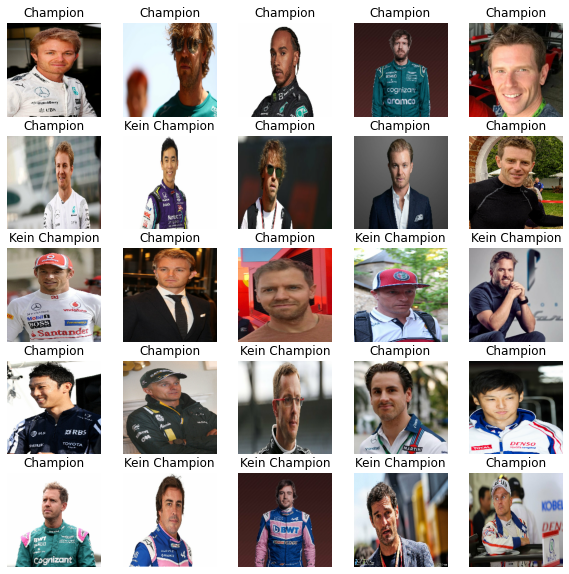

In [61]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We need also to create a test set, that it what the next cell does (basically split the validation in batches and keep 1 for the test)

In [64]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
val_dataset = validation_dataset.skip(val_batches // 2)

In [65]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1
Number of test batches: 0


It is convenient to use buffered prefetching to load images from disk without having I/O become blocking. That is what the next cell does.

In [66]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

As we saw in the class to reduce overfitting, we can increase the diversity within the data by performing data augmentation. Insert here some of the trasnformation you experimented before. And later do notice how actually this doesn't increaese the sample size!!!

In [67]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.2),
    ])

Note: Data augmentation is only active during training. 

Let's repeatedly apply these layers to the same image and see the result.

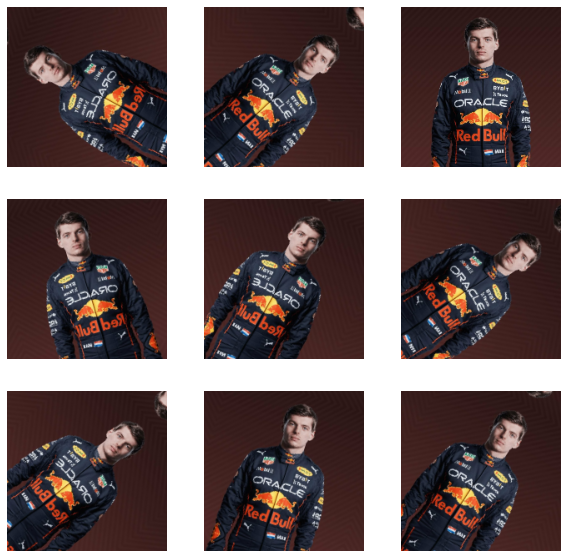

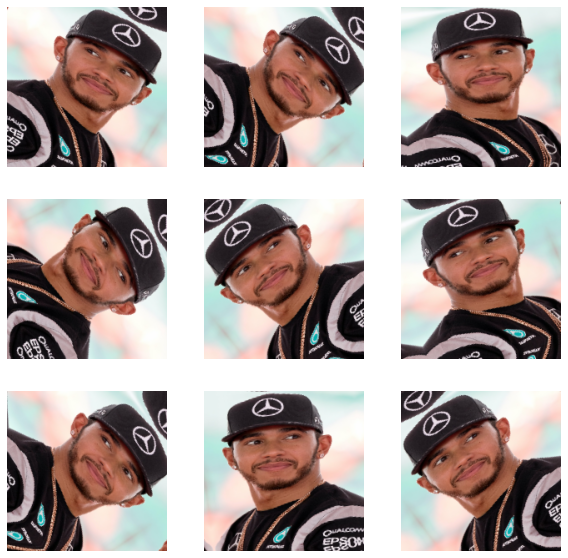

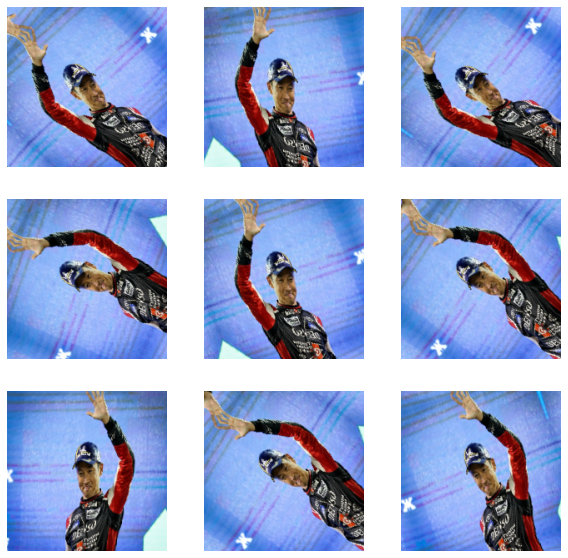

In [69]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(5):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Choose Transfer Learning Model 

As a first execution of the notebook, we will use the following pre-trained model: **MobileNetV2** developed by Google (dowloaded via  `tf.keras.applications.MobileNetV2` ). This will be your base model. The big advantage is that it was trained on ImageNet data! So 1.4M images :) with a wide variety of categories like `jackfruit` and `syringe`. Not on smiles though...Will this help us in recognizing smiles??

Note: Every model was trained using specific image preprocessing requirements. YOU NEED TO CHECK EACH TIME WHAT PECULIAR OF A SPECIFIC MODEL!
Here the guide for MobileNetV2 https://keras.io/api/applications/mobilenet/.

This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. 
At best, you always use the preprocessing method included with the model.

In [70]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [71]:
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

We saw in the lesson that, wen doing trasnfer learning, we don't use all the architecture but only the feature extraction.
The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [72]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `192x192x3` image into a `6x6x1280` block of features. Let's see what it does to an example batch of images:

In [73]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


### a. Freeze weights, use the feature extraction as it is, attach a new classification head
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [74]:
base_model.trainable = False

Let's take a look at the base model architecture

In [75]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

Let's now combine this model with a classification head, meaning some fully connected layers (tf.keras.layers.Dense). 

Build a model by chaining together the data augmentation, preproccesing, `base_model` and classification layers (note that the syntax is slighly different, we are using the [Keras Functional API]).



Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [76]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) #We need to set `training=False` as our model contains a `BatchNormalization` layer. More explanation here https://www.tensorflow.org/guide/keras/transfer_learning
x = tf.keras.layers.GlobalAveragePooling2D()(x) #this layer has the same purpose as tf.keras.layers.Flatten(). Need to connect something 2D to something 1D. Ask if you want to know more :)
#x = tf.keras.layers.Dense(10, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs)


Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [77]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 192, 192, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

Above you see how many parameters you are actually training, and how many are frozen.

### Train the model



In [79]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 3s 3s/step - loss: 0.6428 - accuracy: 0.5789


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.42


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
3/3 [==============================] - 9s 1s/step - loss: 0.9913 - accuracy: 0.3816 - val_loss: 0.8269 - val_accuracy: 0.4211
Epoch 2/20
3/3 [==============================] - 4s 1s/step - loss: 0.8587 - accuracy: 0.4605 - val_loss: 0.8307 - val_accuracy: 0.4211
Epoch 3/20
3/3 [==============================] - 4s 1s/step - loss: 0.8146 - accuracy: 0.4605 - val_loss: 0.8364 - val_accuracy: 0.3684
Epoch 4/20
3/3 [==============================] - 4s 1s/step - loss: 0.8054 - accuracy: 0.4868 - val_loss: 0.8430 - val_accuracy: 0.4211
Epoch 5/20
3/3 [==============================] - 3s 926ms/step - loss: 0.8457 - accuracy: 0.4474 - val_loss: 0.8504 - val_accuracy: 0.4211
Epoch 6/20
3/3 [==============================] - 3s 947ms/step - loss: 0.7849 - accuracy: 0.4868 - val_loss: 0.8580 - val_accuracy: 0.3684
Epoch 7/20
3/3 [==============================] - 4s 1s/step - loss: 0.8282 - accuracy: 0.4737 - val_loss: 0.8652 - val_accuracy: 0.3684
Epoch 8/20
3/3 [===================


Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

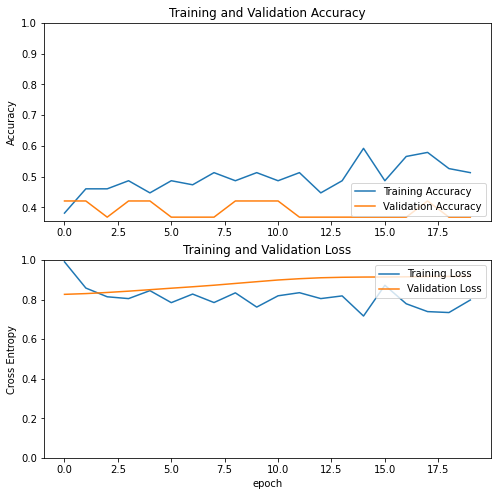

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### b) Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [32]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

Let's keep training from where we stopped before, so we can keep improving hopefully. 

In [39]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/30
3/3 [==============================] - 13s 2s/step - loss: 0.7069 - accuracy: 0.5395 - val_loss: 0.9243 - val_accuracy: 0.4211
Epoch 21/30
3/3 [==============================] - 5s 1s/step - loss: 0.6291 - accuracy: 0.6842 - val_loss: 1.0642 - val_accuracy: 0.4211
Epoch 22/30
3/3 [==============================] - 5s 1s/step - loss: 0.6424 - accuracy: 0.6579 - val_loss: 0.9567 - val_accuracy: 0.4211
Epoch 23/30
3/3 [==============================] - 5s 1s/step - loss: 0.6207 - accuracy: 0.6447 - val_loss: 0.8945 - val_accuracy: 0.3684
Epoch 24/30
3/3 [==============================] - 4s 1s/step - loss: 0.6492 - accuracy: 0.5921 - val_loss: 0.9707 - val_accuracy: 0.4211
Epoch 25/30
3/3 [==============================] - 5s 1s/step - loss: 0.6441 - accuracy: 0.6316 - val_loss: 0.9187 - val_accuracy: 0.4211
Epoch 26/30
3/3 [==============================] - 5s 1s/step - loss: 0.5191 - accuracy: 0.7632 - val_loss: 0.9314 - val_accuracy: 0.4211
Epoch 27/30
3/3 [================

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. Pay attention to not overfit!


In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

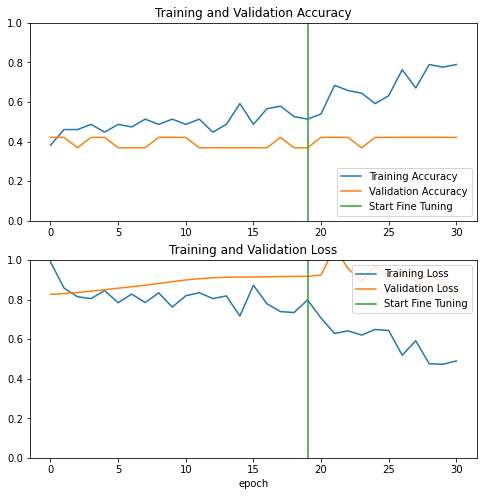

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [42]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

/Applications/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:921: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

And now you are all set to use this model to predict if your pet is a cat or dog.

In [43]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

StopIteration: 

### 4. Test with your own selfie :)

Try to upload a picture of you smiling or not and check whether the model can detect it correctly!

This image most likely belongs to Champion.


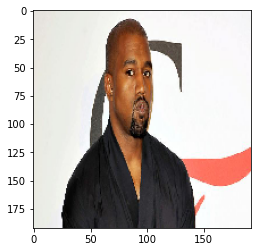

In [47]:
img = tf.keras.utils.load_img("Kanye.jpg", target_size=(192,192)# your own image
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it's the only member.


prediction = model.predict_on_batch(img_array).flatten()

prediction = tf.where(prediction < 0.5, 0, 1)


print(
    "This image most likely belongs to {}."
    .format(class_names[prediction[0]])
)

plt.imshow(img)

### Wrap-up:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. Be aware that fine-tuning is not always the go-for-it solution!It depends

Extra: see also [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
